In [1]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')
T=3055
simdur =3*T

def performance(gsyn12=0.005, gsyn21=0.005, gfb12=0.001, gfb21=0.001):
    sec = h.Section(name='mod')
    sec.insert('brainb')
    sec.insert('bodyb')
    seg = sec(0.5)

    seg.brainb.gsyn12 = gsyn12
    seg.brainb.gsyn21 = gsyn21
    seg.brainb.gfb12 = gfb12
    seg.brainb.gfb21 = gfb21

   
    seg.brainb._ref_L1Pointer = seg.bodyb._ref_L1
    seg.brainb._ref_L2Pointer = seg.bodyb._ref_L2
    seg.bodyb._ref_V1Pointer = seg.brainb._ref_V1
    seg.bodyb._ref_V2Pointer = seg.brainb._ref_V2


    Qv = h.Vector().record(seg.bodyb._ref_Q)
    tv = h.Vector().record(h._ref_t)

    # Simulate
    h.finitialize()
    h.cvode.active(1)
    h.continuerun(simdur)

    Q = np.array(Qv)
    return Q[-1] / simdur  


original_perf = performance()
print(f"Baseline performance (symmetric): {original_perf:.6e}")



Baseline performance (symmetric): 1.230801e-03


 Optimal gsyn12 = 0.003605, Perf = 1.382516e-03
 Optimal gsyn21 = 0.002147, Perf = 1.388027e-03


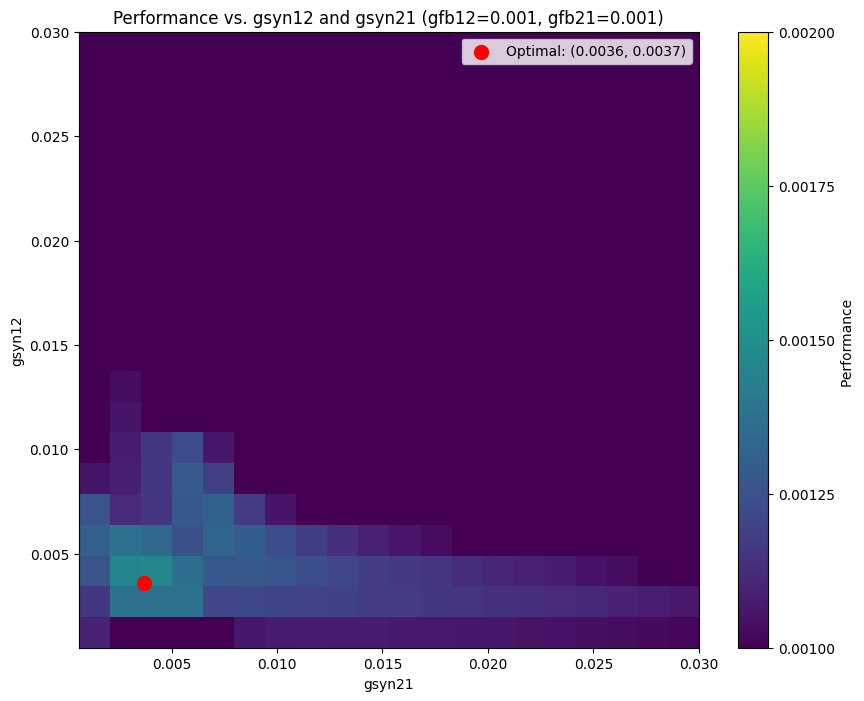

In [2]:

gsyn12_vals = np.linspace(0.0005, 0.03, 20)
perf_gsyn12 = [performance(gsyn12=g) for g in gsyn12_vals]
opt_gsyn12 = gsyn12_vals[np.argmax(perf_gsyn12)]
print(f" Optimal gsyn12 = {opt_gsyn12:.6f}, Perf = {max(perf_gsyn12):.6e}")


gsyn21_vals = np.linspace(0.0006, 0.03, 20)
perf_gsyn21 = [performance(gsyn21=g) for g in gsyn21_vals]
opt_gsyn21 = gsyn21_vals[np.argmax(perf_gsyn21)]
print(f" Optimal gsyn21 = {opt_gsyn21:.6f}, Perf = {max(perf_gsyn21):.6e}")


performance_grid = np.zeros((len(gsyn12_vals), len(gsyn21_vals)))

for i, gs12 in enumerate(gsyn12_vals):
    for j, gs21 in enumerate(gsyn21_vals):
        performance_grid[i, j] = performance(gsyn12=gs12, gsyn21=gs21)

max_perf = np.max(performance_grid)
opt_idx = np.unravel_index(np.argmax(performance_grid), performance_grid.shape)
opt_gsyn12 = gsyn12_vals[opt_idx[0]]
opt_gsyn21 = gsyn21_vals[opt_idx[1]]

plt.figure(figsize=(10, 8))
im = plt.imshow(performance_grid, 
               extent=[gsyn21_vals.min(), gsyn21_vals.max(), gsyn12_vals.min(), gsyn12_vals.max()],
               origin='lower', cmap='viridis', aspect='auto',
               vmin=1e-3, vmax=2e-3)  # Explicit color limits
plt.scatter(opt_gsyn21, opt_gsyn12, color='red', s=100, 
            label=f'Optimal: ({opt_gsyn12:.4f}, {opt_gsyn21:.4f})')
cbar = plt.colorbar(im, label='Performance ')
cbar.set_ticks(np.linspace(1e-3, 2e-3, 5))  

plt.xlabel('gsyn21')
plt.ylabel('gsyn12')
plt.title('Performance vs. gsyn12 and gsyn21 (gfb12=0.001, gfb21=0.001)')
plt.legend()
plt.show()


 Best gfb12 = 0.000200, Perf = 1.375310e-03
 Best gfb21 = 0.003200, Perf = 1.324108e-03


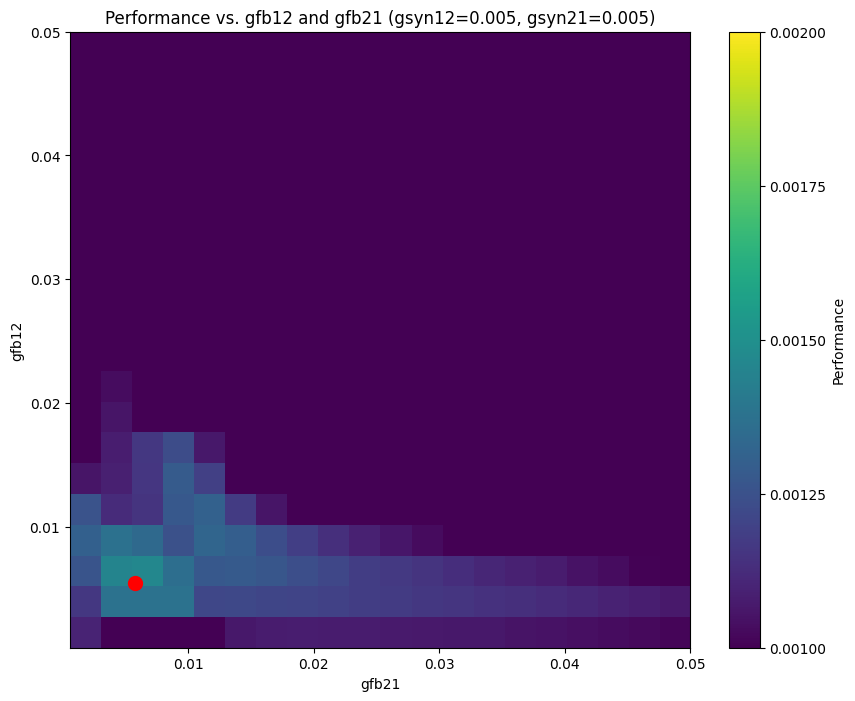

In [5]:
gfb12_vals = np.linspace(0.0002, 0.05, 20)
perf_gfb12 = [performance(gfb12=g) for g in gfb12_vals]
opt_gfb12 = gfb12_vals[np.argmax(perf_gfb12)]
print(f" Best gfb12 = {opt_gfb12:.6f}, Perf = {max(perf_gfb12):.6e}")

gfb21_vals = np.linspace(0.0006, 0.05, 20)
perf_gfb21 = [performance(gfb21=g) for g in gfb21_vals]
opt_gfb21 = gfb21_vals[np.argmax(perf_gfb21)]
print(f" Best gfb21 = {opt_gfb21:.6f}, Perf = {max(perf_gfb21):.6e}")

max_perf = np.max(performance_grid)
opt_idx = np.unravel_index(np.argmax(performance_grid), performance_grid.shape)
opt_gfb12 = gfb12_vals[opt_idx[0]]
opt_gfb21 = gfb21_vals[opt_idx[1]]


plt.figure(figsize=(10, 8))
im = plt.imshow(performance_grid, 
               extent=[gfb21_vals.min(), gfb21_vals.max(), gfb12_vals.min(), gfb12_vals.max()],
               origin='lower', cmap='viridis', aspect='auto',
               vmin=1e-3, vmax=2e-3)  # Fixed range for colorbar


plt.scatter(opt_gfb21, opt_gfb12, color='red', s=100, 
           label=f'Optimal: ({opt_gfb12:.4f}, {opt_gfb21:.4f})')


cbar = plt.colorbar(im, label='Performance')
cbar.set_ticks(np.linspace(1e-3, 2e-3, 5))  
plt.xlabel('gfb21')
plt.ylabel('gfb12')
plt.title('Performance vs. gfb12 and gfb21 (gsyn12=0.005, gsyn21=0.005)')
plt.show()

In [8]:

gsyn12_range = np.linspace(opt_gsyn12 * 0.7, opt_gsyn12 * 1.5, 5)
gsyn21_range = np.linspace(opt_gsyn21 * 0.8, opt_gsyn21 * 1.2, 5)
gfb12_range = np.linspace(opt_gfb12 * 0.6, opt_gfb12 * 1.4, 5)
gfb21_range = np.linspace(opt_gfb21 * 0.75, opt_gfb21 * 1.3, 5)

best_perf = -np.inf
best_params = (0, 0, 0, 0)

for gs12 in gsyn12_range:
    for gs21 in gsyn21_range:
        for gf12 in gfb12_range:
            for gf21 in gfb21_range:
                current_perf = performance(gs12, gs21, gf12, gf21)
                if current_perf > best_perf:
                    best_perf = current_perf
                    best_params = (gs12, gs21, gf12, gf21)
                print(f"gs12={gs12:.4f}, gs21={gs21:.4f}, gf12={gf12:.4f}, gf21={gf21:.4f}, Perf={current_perf:.4e}")

print(f"\n Optimal parameters: gsyn12={best_params[0]:.6f}, gsyn21={best_params[1]:.6f}, gfb12={best_params[2]:.6f}, gfb21={best_params[3]:.6f}")
print(f" Best performance: {best_perf:.6e}")
change = ((best_perf - original_perf) / original_perf )* 100
print(f" Change in performance: {change:.2f}%")

gs12=0.0025, gs21=0.0030, gf12=0.0033, gf21=0.0043, Perf=1.1061e-03
gs12=0.0025, gs21=0.0030, gf12=0.0033, gf21=0.0051, Perf=1.1188e-03
gs12=0.0025, gs21=0.0030, gf12=0.0033, gf21=0.0059, Perf=1.0796e-03
gs12=0.0025, gs21=0.0030, gf12=0.0033, gf21=0.0067, Perf=1.0280e-03
gs12=0.0025, gs21=0.0030, gf12=0.0033, gf21=0.0075, Perf=9.9883e-04
gs12=0.0025, gs21=0.0030, gf12=0.0044, gf21=0.0043, Perf=8.3284e-04
gs12=0.0025, gs21=0.0030, gf12=0.0044, gf21=0.0051, Perf=8.1255e-04
gs12=0.0025, gs21=0.0030, gf12=0.0044, gf21=0.0059, Perf=8.0064e-04
gs12=0.0025, gs21=0.0030, gf12=0.0044, gf21=0.0067, Perf=7.8731e-04
gs12=0.0025, gs21=0.0030, gf12=0.0044, gf21=0.0075, Perf=7.7699e-04
gs12=0.0025, gs21=0.0030, gf12=0.0054, gf21=0.0043, Perf=5.6151e-04
gs12=0.0025, gs21=0.0030, gf12=0.0054, gf21=0.0051, Perf=5.6317e-04
gs12=0.0025, gs21=0.0030, gf12=0.0054, gf21=0.0059, Perf=5.6016e-04
gs12=0.0025, gs21=0.0030, gf12=0.0054, gf21=0.0067, Perf=5.6059e-04
gs12=0.0025, gs21=0.0030, gf12=0.0054, gf21=0.00